In [3]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor


In [4]:
contaminated_df = pd.read_csv("../../data/contaminated/data_contaminated3.csv")
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')


In [5]:
#contaminated_df.head

In [6]:
contaminated_sentences = contaminated_df['combined_text'].tolist()
embeddings = model.encode(contaminated_sentences)

print(embeddings[:5])


[[ 0.28227794  0.12621348 -0.05208312 ... -0.07339635  0.24025863
   0.1327806 ]
 [ 0.43039504  0.03634816 -0.04758246 ... -0.22186738 -0.22349276
   0.06129763]
 [ 0.27479756  0.28263614  0.24597012 ... -0.0940499   0.38327062
   0.55718064]
 [ 0.3451237   0.03631111  0.24890196 ... -0.16847862 -0.6559895
   0.48840496]
 [ 0.35484728  0.07293423  0.34847844 ...  0.02546211  0.13973124
   0.35689235]]


In [7]:
# Normalisation des données

scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)

In [8]:
# Diviser en ensembles d'entraînement et de test
#X_train, X_test = train_test_split(scaled_embeddings, test_size=0.2, random_state=42)
# Séparer les données en train (70%), validation (15%) et test (15%)
X_train, X_temp = train_test_split(scaled_embeddings, test_size=0.3, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

In [9]:
#partie compression de l'entree
input_dim = embeddings.shape[1]
encoding_dim = 32
print(input_dim)

384


In [10]:
input_layer = keras.Input(shape=(input_dim,))
# Encodeur
encoder = layers.Dense(64, activation='relu')(input_layer)
encoder = layers.Dense(encoding_dim, activation='relu')(encoder)

# Décodeur
decoder = layers.Dense(64, activation='relu')(encoder)
decoder = layers.Dense(input_dim, activation='sigmoid')(decoder)

2025-03-17 05:41:10.182029: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [11]:
# Modèle complet
autoencoder = keras.Model(input_layer, decoder)

# Modèle encodeur (pour extraire les features compressées)
encoder_model = keras.Model(input_layer, encoder)

# Compiler le modèle
autoencoder.compile(optimizer='adam', loss='mse')

In [12]:
# Entraîner l'auto-encodeur
autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test)
)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1384 - val_loss: 0.9287
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9046 - val_loss: 0.8533
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8555 - val_loss: 0.8167
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8200 - val_loss: 0.7923
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7901 - val_loss: 0.7754
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7662 - val_loss: 0.7649
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7679 - val_loss: 0.7553
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7602 - val_loss: 0.7489
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7491 - val_loss: 0.7435
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7417 - val_loss: 0.7387
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7465 - val_loss: 0.7350
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7650 - val_lo

In [13]:
# Reconstruire les inputs
reconstructed = autoencoder.predict(scaled_embeddings)

# Calculer l'erreur de reconstruction
mse = np.mean(np.power(scaled_embeddings - reconstructed, 2), axis=1)

# Ajouter les scores d'anomalie au DataFrame
contaminated_df['reconstruction_error'] = mse

# Extraire les embeddings réduits
reduced_embeddings = encoder_model.predict(scaled_embeddings)


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step


In [14]:
reduced_embeddings_df = pd.DataFrame(
    reduced_embeddings, 
    columns=[f'reduced_dim_{i}' for i in range(encoding_dim)]
)

In [30]:
# Sauvegarder les résultats
final_df = pd.concat([contaminated_df, reduced_embeddings_df], axis=1)
final_df.to_csv("../../data/contaminated/autoencoder_results.csv", index=False)

threshold = np.percentile(mse, 95)  # Les 5% supérieurs sont considérés comme anomalies
contaminated_df['is_anomaly_autoencoder'] = mse > threshold
anomalies_percentile = mse > threshold

anomaly_indices_autoencoder = contaminated_df[contaminated_df['is_anomaly_autoencoder'] == True].index.tolist()

print(f"Indices des anomalies détectées par l'autoencodeur : {anomaly_indices_autoencoder}")

print(threshold)
print(f"Nombre d'anomalies détectées (percentile): {sum(anomalies_percentile)}")

Indices des anomalies détectées par l'autoencodeur : [8, 18, 37, 59, 72, 75, 85, 109, 118, 132, 134, 194, 204, 210, 221, 260, 267, 275, 284, 319, 323, 328, 348, 383, 392, 420, 449, 450, 456, 460, 561, 594, 602, 607, 648, 670, 677, 702, 706, 708, 724, 800, 808, 818, 849, 855, 861, 874, 883, 934, 938, 975, 984, 994, 1011, 1095, 1106, 1109, 1124, 1204, 1214, 1218, 1251, 1275, 1278, 1292, 1333, 1334, 1364, 1367, 1396, 1430, 1441, 1466, 1467, 1496, 1511, 1521, 1613, 1639, 1641, 1664, 1674, 1716, 1729, 1731, 1735, 1755, 1771, 1808, 1810, 1858, 1869, 1890, 1894, 1956, 1970, 1993, 1995, 1996, 2007, 2013, 2025, 2056, 2071, 2109, 2112, 2134, 2161, 2178, 2201, 2241, 2252, 2262, 2276, 2281, 2289, 2325, 2368, 2383, 2400, 2408, 2418, 2451, 2453, 2527, 2551, 2554, 2573, 2578, 2584, 2606, 2659, 2674, 2713, 2714, 2754, 2762, 2783, 2785, 2805, 2817, 2820, 2858, 2859, 2970, 3001, 3013, 3014, 3036, 3039, 3049, 3054, 3092, 3105, 3141, 3154, 3171, 3195, 3225, 3249, 3277, 3295, 3299, 3332, 3350, 3373, 3377, 

In [29]:
#cette partie permet juste de voir à quoi ressemble les ambedings après reduction de dimension et voir egalement
#les erreurs de reconstruction pour identifier les anomalies
'''import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Réduire à 2D pour la visualisation si encoding_dim > 2
if encoding_dim > 2:
    tsne = TSNE(n_components=2, random_state=42)
    reduced_2d = tsne.fit_transform(reduced_embeddings)
else:
    reduced_2d = reduced_embeddings

plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_2d[:, 0], reduced_2d[:, 1], 
                     c=mse, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Erreur de reconstruction')
plt.title('Visualisation des embeddings réduits avec erreur de reconstruction')
plt.savefig('embeddings_visualization.png')
plt.show()'''

"import matplotlib.pyplot as plt\nfrom sklearn.manifold import TSNE\n\n# Réduire à 2D pour la visualisation si encoding_dim > 2\nif encoding_dim > 2:\n    tsne = TSNE(n_components=2, random_state=42)\n    reduced_2d = tsne.fit_transform(reduced_embeddings)\nelse:\n    reduced_2d = reduced_embeddings\n\nplt.figure(figsize=(10, 8))\nscatter = plt.scatter(reduced_2d[:, 0], reduced_2d[:, 1], \n                     c=mse, cmap='viridis', alpha=0.7)\nplt.colorbar(scatter, label='Erreur de reconstruction')\nplt.title('Visualisation des embeddings réduits avec erreur de reconstruction')\nplt.savefig('embeddings_visualization.png')\nplt.show()"

In [17]:
contaminated_df.head()

,combined_text,reconstruction_error,is_anomaly_autoencoder
0,cardiac silhouette mediastinum size within nor...,0.399556,False
1,cardiomediastinal silhouette within normal lim...,0.365329,False
2,lung clear epanded heart mediastinum normal ac...,1.391273,False
3,increased_opacity within right_upper_lobe poss...,0.788052,False
4,interstitial marking diffusely prominent throu...,1.120110,False


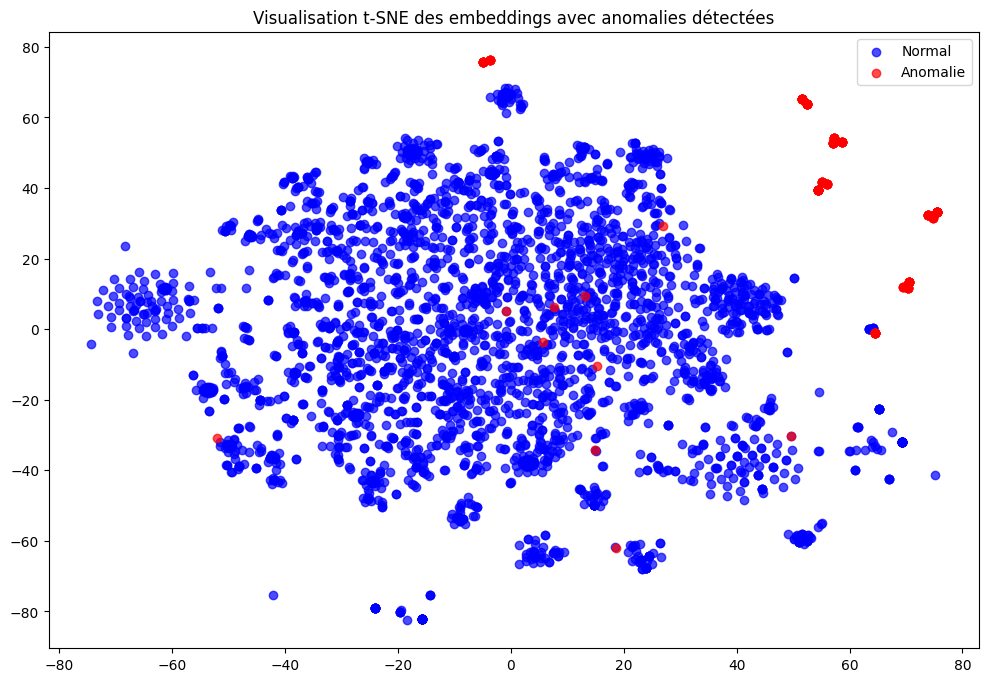

In [18]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embedding_2d = tsne.fit_transform(scaled_embeddings)

plt.figure(figsize=(12, 8))
plt.scatter(embedding_2d[contaminated_df['is_anomaly_autoencoder'] == False, 0], 
            embedding_2d[contaminated_df['is_anomaly_autoencoder'] == False, 1], 
            c='blue', alpha=0.7, label='Normal')

plt.scatter(embedding_2d[contaminated_df['is_anomaly_autoencoder'] == True, 0], 
            embedding_2d[contaminated_df['is_anomaly_autoencoder'] == True, 1], 
            c='red', alpha=0.7, label='Anomalie')

plt.title('Visualisation t-SNE des embeddings avec anomalies détectées')
plt.legend()
plt.show()


In [26]:
# Création d'un DataFrame basé sur X_test
contaminated_df_test = pd.DataFrame(X_test, columns=[f'feature_{i}' for i in range(X_test.shape[1])])

# Isolation Forest (entraînement sur X_train)
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
isolation_forest.fit(X_train)
contaminated_df_test['is_anomaly_iforest'] = isolation_forest.predict(X_test) == -1

anomaly_indices_iforest = contaminated_df_test[contaminated_df_test['is_anomaly_iforest'] == True].index.tolist()


#print(f"Indices des anomalies détectées par Isolation Forest : {anomaly_indices_iforest}")


Indices des anomalies détectées par Isolation Forest : [1, 60, 63, 88, 95, 99, 118, 145, 197, 241, 256, 273, 298, 327, 331, 339, 365, 402, 419, 427, 449, 458, 487, 490, 501]


In [28]:
oc_svm = OneClassSVM(nu=0.05, kernel='rbf')
oc_svm.fit(X_train)
contaminated_df_test['is_anomaly_ocsvm'] = oc_svm.predict(X_test) == -1  # -1 pour anomalie, 1 pour normal
anomaly_indices_ocsvm = contaminated_df_test[contaminated_df_test['is_anomaly_ocsvm'] == True].index.tolist()
#print(f"Indices des anomalies détectées par One-Class SVM : {anomaly_indices_ocsvm}")


In [21]:
# Sauvegarde des résultats
#contaminated_df_test.to_csv("../../data/contaminated/anomaly_detection_results.csv", index=False)

In [22]:
# Affichage des résultats
print(f"Nombre d'anomalies détectées - Autoencodeur: {sum(contaminated_df['is_anomaly_autoencoder'])}")
print(f"Nombre d'anomalies détectées - Isolation Forest: {sum(contaminated_df_test['is_anomaly_iforest'])}")
print(f"Nombre d'anomalies détectées - One-Class SVM: {sum(contaminated_df_test['is_anomaly_ocsvm'])}")

Nombre d'anomalies détectées - Autoencodeur: 171
Nombre d'anomalies détectées - Isolation Forest: 25
Nombre d'anomalies détectées - One-Class SVM: 46


In [25]:
indices_df = pd.read_csv("../../data/contaminated/anomaly_indices.csv")
anomaly_indices_true = indices_df['anomaly_indices'].tolist()

#print(f"Indices des anomalies réelles : {anomaly_indices_true}")

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Créer un vecteur binaire pour les anomalies réelles (1 = anomalie, 0 = normal)
y_true = [1 if i in anomaly_indices_true else 0 for i in range(len(X_test))]

y_pred_iforest = [1 if i in anomaly_indices_iforest else 0 for i in range(len(X_test))]
y_pred_ocsvm = [1 if i in anomaly_indices_ocsvm else 0 for i in range(len(X_test))]
y_pred_autoencoder = [1 if i in anomaly_indices_autoencoder else 0 for i in range(len(X_test))]

# Calculer la précision, le rappel et la F-mesure pour chaque modèle
precision_iforest = precision_score(y_true, y_pred_iforest)
recall_iforest = recall_score(y_true, y_pred_iforest)
f1_iforest = f1_score(y_true, y_pred_iforest)

precision_ocsvm = precision_score(y_true, y_pred_ocsvm)
recall_ocsvm = recall_score(y_true, y_pred_ocsvm)
f1_ocsvm = f1_score(y_true, y_pred_ocsvm)

precision_autoencoder = precision_score(y_true, y_pred_autoencoder)
recall_autoencoder = recall_score(y_true, y_pred_autoencoder)
f1_autoencoder = f1_score(y_true, y_pred_autoencoder)

# Calculer l'AUC-ROC pour chaque modèle
y_score_iforest = isolation_forest.decision_function(X_test)  # Scores de probabilité
y_score_ocsvm = oc_svm.decision_function(X_test)  # Scores de probabilité
y_score_autoencoder = mse  # Utiliser l'erreur de reconstruction comme score

roc_auc_iforest = roc_auc_score(y_true, y_score_iforest)
roc_auc_ocsvm = roc_auc_score(y_true, y_score_ocsvm)
roc_auc_autoencoder = roc_auc_score(y_true, y_score_autoencoder)

# Afficher les résultats
print(f"Isolation Forest - Precision: {precision_iforest}, Recall: {recall_iforest}, F1-Score: {f1_iforest}, AUC-ROC: {roc_auc_iforest}")
print(f"One-Class SVM - Precision: {precision_ocsvm}, Recall: {recall_ocsvm}, F1-Score: {f1_ocsvm}, AUC-ROC: {roc_auc_ocsvm}")
print(f"Autoencoder - Precision: {precision_autoencoder}, Recall: {recall_autoencoder}, F1-Score: {f1_autoencoder}, AUC-ROC: {roc_auc_autoencoder}")


ValueError: Found input variables with inconsistent numbers of samples: [513, 3419]